In [34]:
!pip install kaggle

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!mkdir -p ~/ .kaggle

In [11]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/

In [12]:
!chmod 600 ~/ .kaggle/kaggle.json

In [13]:
!kaggle datasets download -d humansintheloop/teeth-segmentation-on-dental-x-ray-images

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images
License(s): CC0-1.0
... resuming from 1501560832 bytes (2945595841 bytes left) ...
100% 4.13G/4.14G [00:21<00:00, 105MB/s] 
100% 4.14G/4.14G [00:21<00:00, 137MB/s]


In [14]:
!unzip teeth-segmentation-on-dental-x-ray-images.zip

Archive:  teeth-segmentation-on-dental-x-ray-images.zip
  inflating: Teeth Segmentation JSON/d2/ann/1.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/10.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/100.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/101.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/102.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/103.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/104.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/105.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/106.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/107.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/108.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/109.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/11.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/110.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/111.jpg.json  
  inflating: Teeth Segmentation JSON/d2/ann/112.jpg.json  
  in

In [15]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [16]:
!pip install split-folders


In [17]:
PRE = "/content/Teeth Segmentation PNG"

In [18]:
import splitfolders
input_folder = PRE +'/d2/'
splitfolders.ratio(input_folder, output="data", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values


Copying files: 2392 files [00:19, 122.73 files/s]


In [8]:
"""
For semantic segmentation the folder structure needs to look like below
if you want to use ImageDatagenerator.

Data/
    train_images/
                train/
                    img1, img2, img3, ......

    train_masks/
                train/
                    msk1, msk, msk3, ......

    val_images/
                val/
                    img1, img2, img3, ......

    val_masks/
                val/
                    msk1, msk, msk3, ......

    test_images/
                test/
                    img1, img2, img3, ......

    test_masks/
                test/
                    msk1, msk, msk3, ......


"""



'\nFor semantic segmentation the folder structure needs to look like below\nif you want to use ImageDatagenerator.\n\nData/\n    train_images/\n                train/\n                    img1, img2, img3, ......\n\n    train_masks/\n                train/\n                    msk1, msk, msk3, ......\n\n    val_images/\n                val/\n                    img1, img2, img3, ......\n\n    val_masks/\n                val/\n                    msk1, msk, msk3, ......\n\n    test_images/\n                test/\n                    img1, img2, img3, ......\n\n    test_masks/\n                test/\n                    msk1, msk, msk3, ......\n\n\n'

In [183]:
seed=24
batch_size=  32
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(
                      rescale = 1/255.,
                         #rotation_range=90,
                      #width_shift_range=0.3,
                      #height_shift_range=0.3,
                      #shear_range=0.5,
                      #zoom_range=0.3,
                      #horizontal_flip=True,
                      #vertical_flip=True,
                      #fill_mode='reflect'
                         )

mask_data_gen_args = dict(
                      rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                        #rotation_range=90,
                      #width_shift_range=0.3,
                      #height_shift_range=0.3,
                      #shear_range=0.5,
                      #zoom_range=0.3,
                      #horizontal_flip=True,
                      #vertical_flip=True,
                      #fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.

#If You need to resize images then add this to the flow_from_directory parameters
#target_size=(150, 150), #Or whatever the size is for your network


In [184]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("/content/data/train_images/",
                                                           seed=seed,target_size=(256, 256),
                                                           batch_size=batch_size,
                                                           color_mode = "grayscale",
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays
                                                                            #thinking class mode is binary.




Found 478 images belonging to 1 classes.


In [185]:
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory("/content/data/train_masks/",
                                                         seed=seed, target_size=(256, 256),
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


Found 478 images belonging to 1 classes.


In [186]:
valid_img_generator = image_data_generator.flow_from_directory("/content/data/val_images/",
                                                               seed=seed, target_size=(256, 256),
                                                               batch_size=batch_size,
                                                               color_mode = "grayscale",
                                                               class_mode=None) #Default batch size 32, if not specified here


Found 59 images belonging to 1 classes.


In [187]:
valid_mask_generator = mask_data_generator.flow_from_directory("/content/data/val_masks/",
                                                               seed=seed, target_size=(256, 256),
                                                               batch_size=batch_size,
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


Found 59 images belonging to 1 classes.


In [188]:
#train_generator = zip(image_generator, mask_generator)
#val_generator = zip(valid_img_generator, valid_mask_generator)


# Sanity Check!

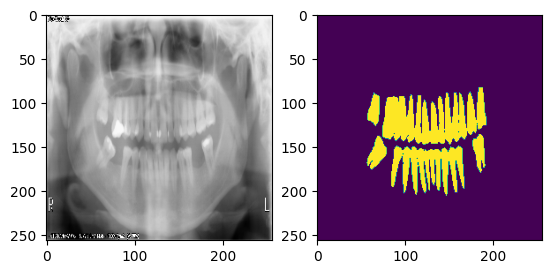

In [189]:
x = next(image_generator)
y = next(mask_generator)
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


In [190]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
CHANNELS = 1

In [191]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred):
     smooth = 1.
     y_true_f = K.flatten(y_true)
     y_pred_f = K.flatten(y_pred)
     intersection = K.sum(y_true_f * y_pred_f)
     score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
     return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [132]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

'''
Here an implementation of the unnet model
This takes input that are already normalized.

Unet in few words:
- A contraction path
- A expansive path
- Skip-connections (concating means adding volume)
'''

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])
    model.summary()

    return model


In [133]:
model = simple_unet_model(IMG_HEIGHT,IMG_WIDTH,CHANNELS)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 256, 256, 16)   │            160 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 256, 256, 16)   │              0 │ conv2d_76[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ dropout_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 128, 128, 16)   │              0 │ conv2d_77[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_37 (Dropout)      │ (None, 128, 128, 32)   │              0 │ conv2d_78[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_37[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 64, 64, 32)     │              0 │ conv2d_79[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_38 (Dropout)      │ (None, 64, 64, 64)     │              0 │ conv2d_80[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ dropout_38[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 32, 32, 64)     │              0 │ conv2d_81[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_82 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_39 (Dropout)      │ (None, 32, 32, 128)    │              0 │ conv2d_82[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_83 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ dropout_39[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 16, 16, 128)    │              0 │ conv2d_83[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [193]:
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.keras', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),checkpointer ]

In [194]:
# Define the combined generator function
def combined_generator(image_gen, mask_gen):
    while True:
        image_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield (image_batch, mask_batch)

# Create the combined generators
train_generator = combined_generator(image_generator, mask_generator)
val_generator = combined_generator(valid_img_generator, valid_mask_generator)


In [ ]:
num_train_imgs = len(os.listdir('/content/data/train_images/img'))

steps_per_epoch = num_train_imgs //batch_size

history = model.fit(train_generator, validation_data=val_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch, epochs=50)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8670 - loss: 0.9991

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks= callbacks,
                    shuffle=True)

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#IOU
# 1 if perfect overlapping, 0 otherwise
y_pred=model.predict(X_test)
y_pred_thresholded = (y_pred > 0.5).astype(int)

intersection = np.logical_and(y_pred_thresholded, y_test)
union = np.logical_or(y_pred_thresholded, y_test)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
plt.subplot(1,2,1)
plt.title("Mask and Image for semantic segmentation")
plt.imshow(y_test[4])
plt.subplot(1,2,2)
plt.imshow(X_test[4])
plt.show()

In [ ]:
plt.imshow(y_pred_thresholded[4])
plt.show()